# Fine-tuning the recognizer

### 1. **import library**

### 2. **Pretrained model architecture**

### 3. **Added Custom Layers**

### 4. **Adjusted Hyperparameters**

### 5. **New model architecture**

### 6. **New model summary before Frozen**

### 7. **Frozen Layers**

### 8. **New model summary after Frozen**

### 9. **Training new model on 94 Class ASCII Image OCR Dataset**

### 10. **Save new model weights**

### 11. **finally Test the new model on ingredient data**


<br/>

# 1. Import libraries

---

In [ ]:
import os
os.environ['TF_MEMORY_ALLOCATED'] = '0.5'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false'
os.environ['MEMORY_GROWTH'] = 'false'
os.environ['MEMORY_ALLOCATED'] = '0.5'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

import keras_ocr
keras_ocr.config.configure()

import matplotlib.pyplot as plt
import numpy as np
import imgaug
from sklearn.model_selection import train_test_split
import pandas as pd

In [4]:
# pretrained_model = backbone model + base model
pretrained_model = keras_ocr.recognition.Recognizer(
    alphabet='0123456789abcdefghijklmnopqrstuvwxyz',
    weights="kurapan"  # pretrained weights
)

Looking for /home/font/.keras-ocr/crnn_kurapan.h5


<br/>

# 2. Pretrained model architecture
---

In [5]:
# Backbone model layers from 0 to 25
print(len(pretrained_model.backbone.layers))
print("backbone model layers name")
pretrained_model.backbone.layers


25
backbone model layers name


[<InputLayer name=input_layer_4, built=True>,
 <Permute name=permute_1, built=True>,
 <Lambda name=lambda_4, built=True>,
 <Conv2D name=conv_1, built=True>,
 <Conv2D name=conv_2, built=True>,
 <Conv2D name=conv_3, built=True>,
 <BatchNormalization name=bn_3, built=True>,
 <MaxPooling2D name=maxpool_3, built=True>,
 <Conv2D name=conv_4, built=True>,
 <Conv2D name=conv_5, built=True>,
 <BatchNormalization name=bn_5, built=True>,
 <MaxPooling2D name=maxpool_5, built=True>,
 <Conv2D name=conv_6, built=True>,
 <Conv2D name=conv_7, built=True>,
 <BatchNormalization name=bn_7, built=True>,
 <Functional name=functional_5, built=True>,
 <Lambda name=lambda_5, built=True>,
 <Reshape name=reshape, built=True>,
 <Dense name=fc_9, built=True>,
 <LSTM name=lstm_10, built=True>,
 <LSTM name=lstm_10_back, built=True>,
 <Add name=add_1, built=True>,
 <LSTM name=lstm_11, built=True>,
 <LSTM name=lstm_11_back, built=True>,
 <Concatenate name=concatenate_1, built=True>]

In [6]:
# Base model layers from 25 to 28
print(len(pretrained_model.model.layers))
print("base model layers name")
pretrained_model.model.layers

28
base model layers name


[<InputLayer name=input_layer_4, built=True>,
 <Permute name=permute_1, built=True>,
 <Lambda name=lambda_4, built=True>,
 <Conv2D name=conv_1, built=True>,
 <Conv2D name=conv_2, built=True>,
 <Conv2D name=conv_3, built=True>,
 <BatchNormalization name=bn_3, built=True>,
 <MaxPooling2D name=maxpool_3, built=True>,
 <Conv2D name=conv_4, built=True>,
 <Conv2D name=conv_5, built=True>,
 <BatchNormalization name=bn_5, built=True>,
 <MaxPooling2D name=maxpool_5, built=True>,
 <Conv2D name=conv_6, built=True>,
 <Conv2D name=conv_7, built=True>,
 <BatchNormalization name=bn_7, built=True>,
 <Functional name=functional_5, built=True>,
 <Lambda name=lambda_5, built=True>,
 <Reshape name=reshape, built=True>,
 <Dense name=fc_9, built=True>,
 <LSTM name=lstm_10, built=True>,
 <LSTM name=lstm_10_back, built=True>,
 <Add name=add_1, built=True>,
 <LSTM name=lstm_11, built=True>,
 <LSTM name=lstm_11_back, built=True>,
 <Concatenate name=concatenate_1, built=True>,
 <Dropout name=dropout, built=True>

### Model architecture

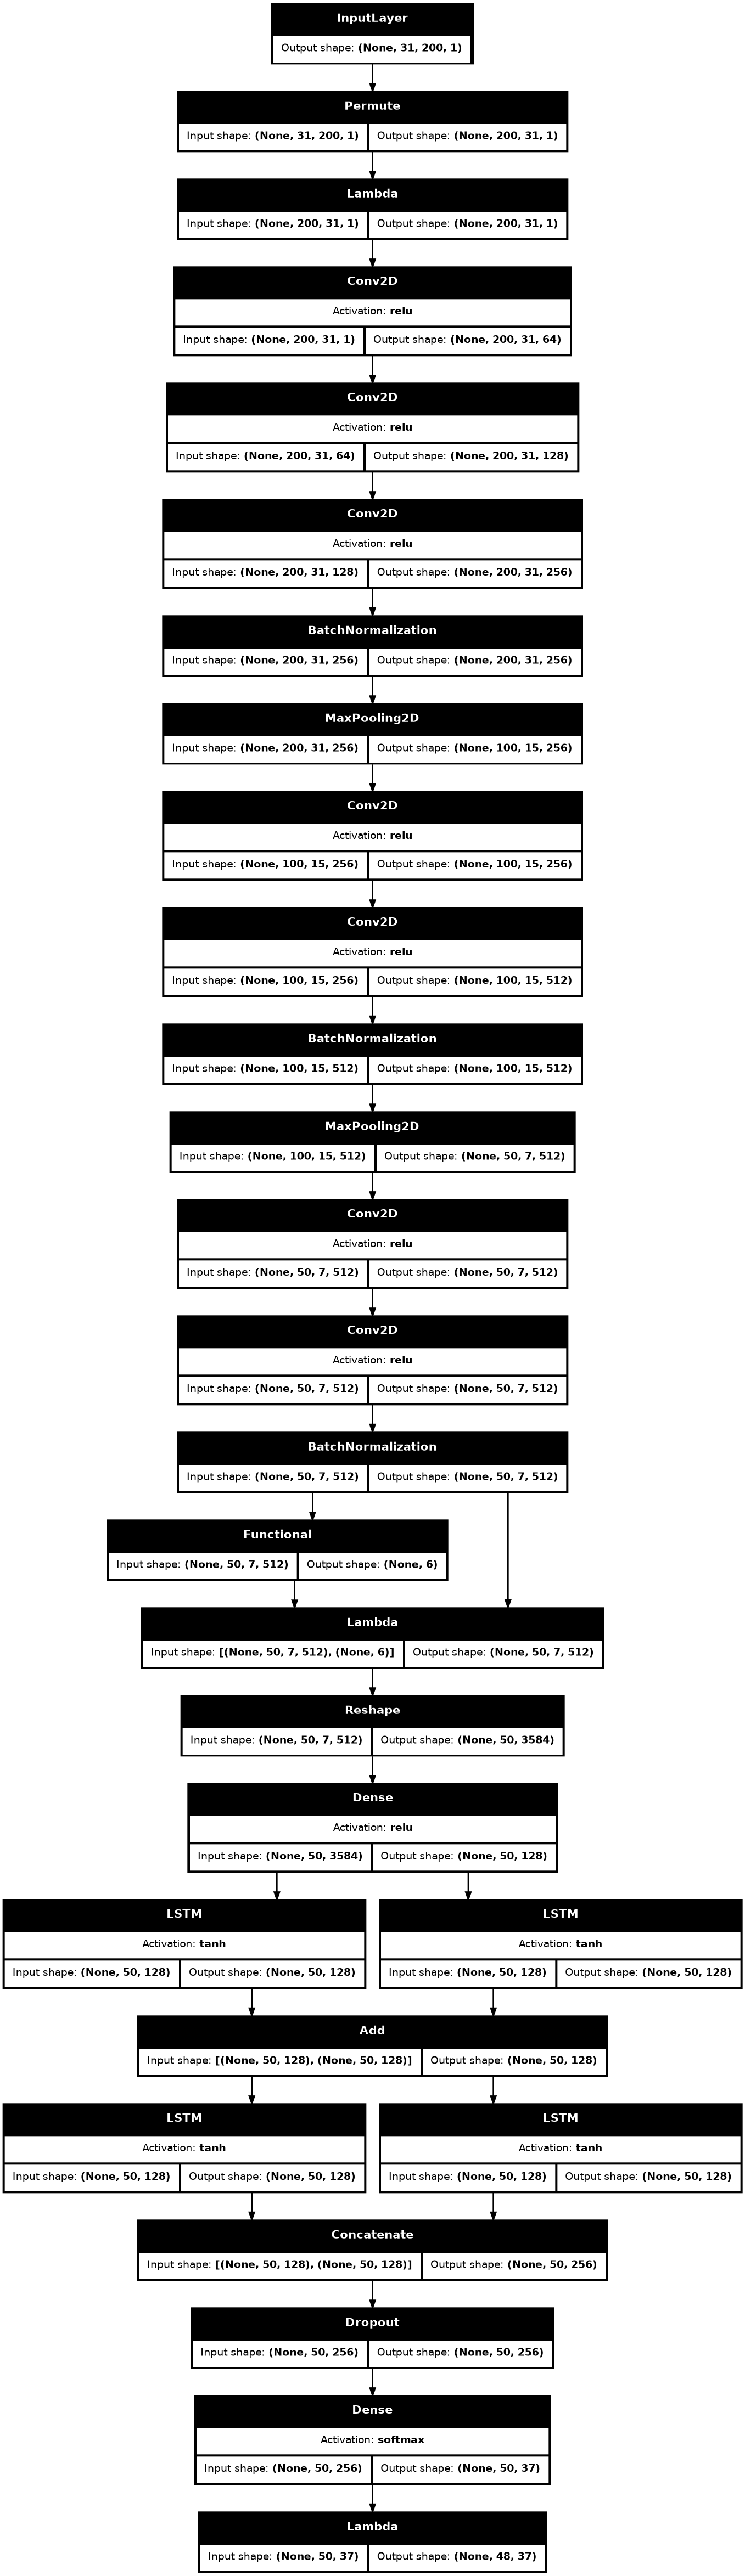

In [7]:
tf.keras.utils.plot_model(
    pretrained_model.model,
    show_shapes = True,
    show_layer_activations = True,
    dpi=96
)

In [8]:
pretrained_model.model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 31, 200,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 200, 31,   │          0 │ input_layer_4[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 200, 31,   │          0 │ permute_1[0][0]   │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 200, 31,   │        640 │ lambda_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, 200, 31,   │     73,856 │ conv_1[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv2D)     │ (None, 200, 31,   │    295,168 │ conv_2[0][0]      │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_3                │ (None, 200, 31,   │      1,024 │ conv_3[0][0]      │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool_3           │ (None, 100, 15,   │          0 │ bn_3[0][0]        │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4 (Conv2D)     │ (None, 100, 15,   │    590,080 │ maxpool_3[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_5 (Conv2D)     │ (None, 100, 15,   │  1,180,160 │ conv_4[0][0]      │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_5                │ (None, 100, 15,   │      2,048 │ conv_5[0][0]      │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool_5           │ (None, 50, 7,     │          0 │ bn_5[0][0]        │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_6 (Conv2D)     │ (None, 50, 7,     │  2,359,808 │ maxpool_5[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_7 (Conv2D)     │ (None, 50, 7,     │  2,359,808 │ conv_6[0][0]      │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_7                │ (None, 50, 7,     │      2,048 │ conv_7[0][0]      │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 6)         │    934,902 │ bn_7[0][0]        │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 50, 7,     │          0 │ bn_7[0][0],     

 Total params: 8,794,267 (33.55 MB)

 Trainable params: 8,791,707 (33.54 MB)

 Non-trainable params: 2,560 (10.00 KB)

<br/>

# 3. Add custom layers
---

In [9]:
model_input = pretrained_model.model.input

fc_12_output = pretrained_model.model.get_layer('fc_12').output

# Continue from fc_12_output
x = fc_12_output

x = tf.keras.layers.Dense(128, activation='relu', name='custom_dense_1')(x)

x = tf.keras.layers.Dropout(0.5, name='custom_dropout')(x)

x = tf.keras.layers.Dense(
  len(pretrained_model.alphabet) + 1,  # +1 for the CTC blank symbol
  activation='softmax',
  name='custom_output_dense'
)(x)

def slice_lambda(x):
  return x[:, :-2, :]

x = tf.keras.layers.Lambda(
  function=slice_lambda,
  name='lambda_30'
)(x)

new_model = tf.keras.models.Model(inputs=model_input, outputs=x)

pretrained_model.model = new_model

<br/>

# 4. Adjusted Hyperparameters
---

In [10]:
new_model.prediction_model = tf.keras.models.Model(
  inputs=model_input,
  outputs=pretrained_model.model.output
)

In [11]:
# Compile the training model
new_model.compile(
  optimizer='adam',
  loss={'ctc_loss': lambda y_true, y_pred: y_pred}
)

pretrained_model.compile()

<br/>

# 5. New model architecture
---

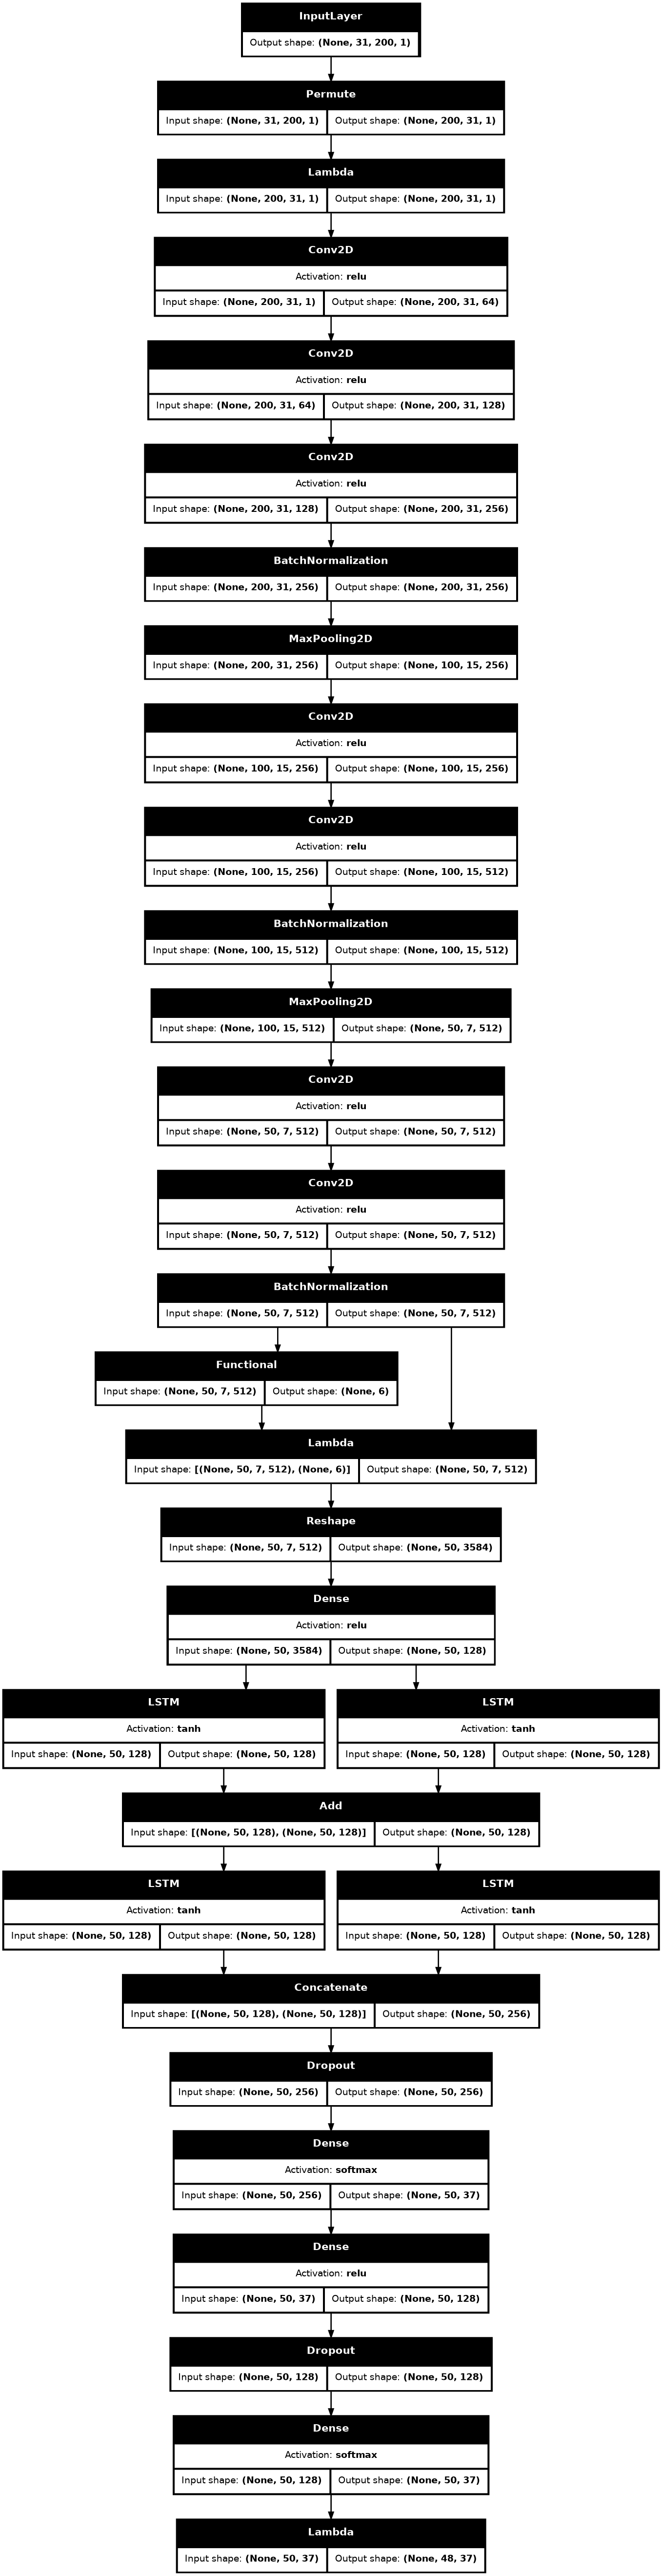

In [12]:
tf.keras.utils.plot_model(
    new_model,
    show_shapes = True,
    show_layer_activations = True,
    dpi=96
)

<br/>

# 6. New model summary before Frozen
---

In [13]:
new_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 31, 200,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 200, 31,   │          0 │ input_layer_4[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 200, 31,   │          0 │ permute_1[0][0]   │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 200, 31,   │        640 │ lambda_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, 200, 31,   │     73,856 │ conv_1[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv2D)     │ (None, 200, 31,   │    295,168 │ conv_2[0][0]      │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_3                │ (None, 200, 31,   │      1,024 │ conv_3[0][0]      │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool_3           │ (None, 100, 15,   │          0 │ bn_3[0][0]        │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4 (Conv2D)     │ (None, 100, 15,   │    590,080 │ maxpool_3[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_5 (Conv2D)     │ (None, 100, 15,   │  1,180,160 │ conv_4[0][0]      │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_5                │ (None, 100, 15,   │      2,048 │ conv_5[0][0]      │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool_5           │ (None, 50, 7,     │          0 │ bn_5[0][0]        │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_6 (Conv2D)     │ (None, 50, 7,     │  2,359,808 │ maxpool_5[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_7 (Conv2D)     │ (None, 50, 7,     │  2,359,808 │ conv_6[0][0]      │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_7                │ (None, 50, 7,     │      2,048 │ conv_7[0][0]      │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 6)         │    934,902 │ bn_7[0][0]        │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 50, 7,     │          0 │ bn_7[0][0],     

 Total params: 8,803,904 (33.58 MB)

 Trainable params: 8,801,344 (33.57 MB)

 Non-trainable params: 2,560 (10.00 KB)

<br/>

# 7. Frozen Layers
---

In [14]:
for layer in new_model.layers[:27]: 
    layer.trainable = False

<br/>

# 8. New model summary after Frozen
---

In [15]:
new_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 31, 200,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 200, 31,   │          0 │ input_layer_4[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 200, 31,   │          0 │ permute_1[0][0]   │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 200, 31,   │        640 │ lambda_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, 200, 31,   │     73,856 │ conv_1[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv2D)     │ (None, 200, 31,   │    295,168 │ conv_2[0][0]      │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_3                │ (None, 200, 31,   │      1,024 │ conv_3[0][0]      │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool_3           │ (None, 100, 15,   │          0 │ bn_3[0][0]        │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4 (Conv2D)     │ (None, 100, 15,   │    590,080 │ maxpool_3[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_5 (Conv2D)     │ (None, 100, 15,   │  1,180,160 │ conv_4[0][0]      │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_5                │ (None, 100, 15,   │      2,048 │ conv_5[0][0]      │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool_5           │ (None, 50, 7,     │          0 │ bn_5[0][0]        │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_6 (Conv2D)     │ (None, 50, 7,     │  2,359,808 │ maxpool_5[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_7 (Conv2D)     │ (None, 50, 7,     │  2,359,808 │ conv_6[0][0]      │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_7                │ (None, 50, 7,     │      2,048 │ conv_7[0][0]      │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 6)         │    934,902 │ bn_7[0][0]        │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 50, 7,     │          0 │ bn_7[0][0],     

 Total params: 8,803,904 (33.58 MB)

 Trainable params: 9,637 (37.64 KB)

 Non-trainable params: 8,794,267 (33.55 MB)

<br/>

# 9. Training new model on 94 Class ASCII Image OCR Dataset
---

In [22]:
images_path = './dataset/94-Class-ASCII-Image-OCR-Data-main/'
images_subpath_labels = list({
    'exclamation_mark': '!',
    'hash': '#',
    'dollar': '$',
    'percent': '%',
    'ampersand': '&',
    'apostrophe': "'",
    'left_parenthesis': '(',
    'right_parenthesis': ')',
    'plus': '+',
    'comma': ',',
    'minus': '-',
    'zero': '0',
    'one': '1',
    'two': '2',
    'three': '3',
    'four': '4',
    'five': '5',
    'six': '6',
    'seven': '7',
    'eight': '8',
    'nine': '9',
    'semicolon': ';',
    'at': '@',
    'left_bracket': '[',
    'right_bracket': ']',
    'caret': '^',
    'underscore': '_',
    'backtick': '`',
    'a': 'a',
    'b': 'b',
    'backslash': 'bslash',
    'c': 'c',
    'colon': 'colon',
    'd': 'd',
    'dot': 'dot',
    'double_quotes': 'dqts',
    'e': 'e',
    'equal': 'equal',
    'f': 'f',
    'g': 'g',
    'greater_than': 'greater',
    'h': 'h',
    'i': 'i',
    'j': 'j',
    'k': 'k',
    'l': 'l',
    'less_than': 'less',
    'm': 'm',
    'n': 'n',
    'o': 'o',
    'or': 'or',
    'p': 'p',
    'q': 'q',
    'question_mark': 'qmark',
    'r': 'r',
    's': 's',
    'slash': 'slash',
    'asterisk': 'star',
    't': 't',
    'u': 'u',
    'v': 'v',
    'w': 'w',
    'x': 'x',
    'y': 'y',
    'z': 'z',
    'left_curly_brace': '{',
    'right_curly_brace': '}',
    'tilde': '~'
}.items())


In [23]:
train_labels = []
for i in images_subpath_labels:
    dir_path = images_path + i[1]
    for j in os.listdir(dir_path):
        add = (dir_path + '/' + j, None, i[0])
        train_labels.append(add)

In [24]:
batch_size = 32
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

train_labels, validation_labels = train_test_split(train_labels, test_size=0.3, random_state=42)

(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=new_model.input_shape[1],
            width=new_model.input_shape[2],
            alphabet=pretrained_model.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]
]

training_gen, validation_gen = [
    pretrained_model.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

In [25]:
train_labels

[('./dataset/94-Class-ASCII-Image-OCR-Data-main/dqts/SimSun_12.png',
  None,
  'double_quotes'),
 ('./dataset/94-Class-ASCII-Image-OCR-Data-main/s/CenturySchoolbookfont_3.png',
  None,
  's'),
 ('./dataset/94-Class-ASCII-Image-OCR-Data-main/(/RockwellNovaLight_0.png',
  None,
  'left_parenthesis'),
 ('./dataset/94-Class-ASCII-Image-OCR-Data-main/u/Corbel_0.png', None, 'u'),
 ('./dataset/94-Class-ASCII-Image-OCR-Data-main/bslash/Abadi_4.png',
  None,
  'backslash'),
 ('./dataset/94-Class-ASCII-Image-OCR-Data-main/l/PalatinoLinotype_2.png',
  None,
  'l'),
 ('./dataset/94-Class-ASCII-Image-OCR-Data-main/n/CourierNew_4_1.png',
  None,
  'n'),
 ('./dataset/94-Class-ASCII-Image-OCR-Data-main/,/BookAntiqua_1.png',
  None,
  'comma'),
 ('./dataset/94-Class-ASCII-Image-OCR-Data-main/v/CalistoMT_4.png', None, 'v'),
 ('./dataset/94-Class-ASCII-Image-OCR-Data-main/a/Ebrima_3_1.png', None, 'a'),
 ('./dataset/94-Class-ASCII-Image-OCR-Data-main/9/Engravers_MT_2.png',
  None,
  'nine'),
 ('./dataset/

In [26]:
training_steps # 386

386

In [27]:
pretrained_model.training_model.input_shape

[(None, 31, 200, 1), (None, 48), (None, 1), (None, 1)]

### Train the model

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=False),
]

In [34]:
pretrained_model.training_model.fit(
        training_gen,
        steps_per_epoch=training_steps,
        validation_steps=validation_steps,
        validation_data=validation_gen,
        epochs=10,
)

Epoch 1/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step 
Epoch 2/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step 
Epoch 3/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step 
Epoch 4/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step 
Epoch 5/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step 
Epoch 6/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step 
Epoch 7/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step 
Epoch 8/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step 
Epoch 9/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step 
Epoch 10/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step 


# 10. Save new model weights

In [36]:
pretrained_model.training_model.save('new_model_weights.h5')

# 11. Test the new model on ingredient data

In [37]:
pipeline = keras_ocr.pipeline.Pipeline(recognizer=pretrained_model)

Looking for /home/font/.keras-ocr/craft_mlt_25k.h5


In [38]:
ingredient_images_path = "dataset/ingredient/img/"
extensions = ['.png', '.jpg', '.jpeg']
ingredient_images_names =  pd.read_csv('dataset/ingredient/label.csv')['nama']
ingredient_labels = pd.read_csv('dataset/ingredient/label.csv')['label']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image number 1
komposisi dataset/ingredient/img/komposisi.jpg
New model result:
komposisi gumx sodium acrylates xanthan aquas allantoin pca chlorphenesin crosspolymer sodium sodium glycerin propanediol phenoxyethano l cinnamomum centella asiatica extract hyaluronate d niacinamide zeylanicum bark extracty panthenol d royal arbutin resveratrol polyquaterniuml jelly notes ingredients from natural resourcesi
Actually result:
Komposisi: Aqua, Xanthan Gum*, Sodium Acrylates, Crossspolymer, Sodium Allantoin PCA, Chlorphenesin, Phenoxyethanol, Glycerin, Propanediol, Sodium Hyaluronate, Centella Asiatica Extract*, Cinnamomum Zeylanicum Bark Extract*, Panthenol, Niacinamide, Royal Jelly*, Arbutin, Resveratrol, Polyquaternium-7. (Note: *Ingredients From Natural Resources)


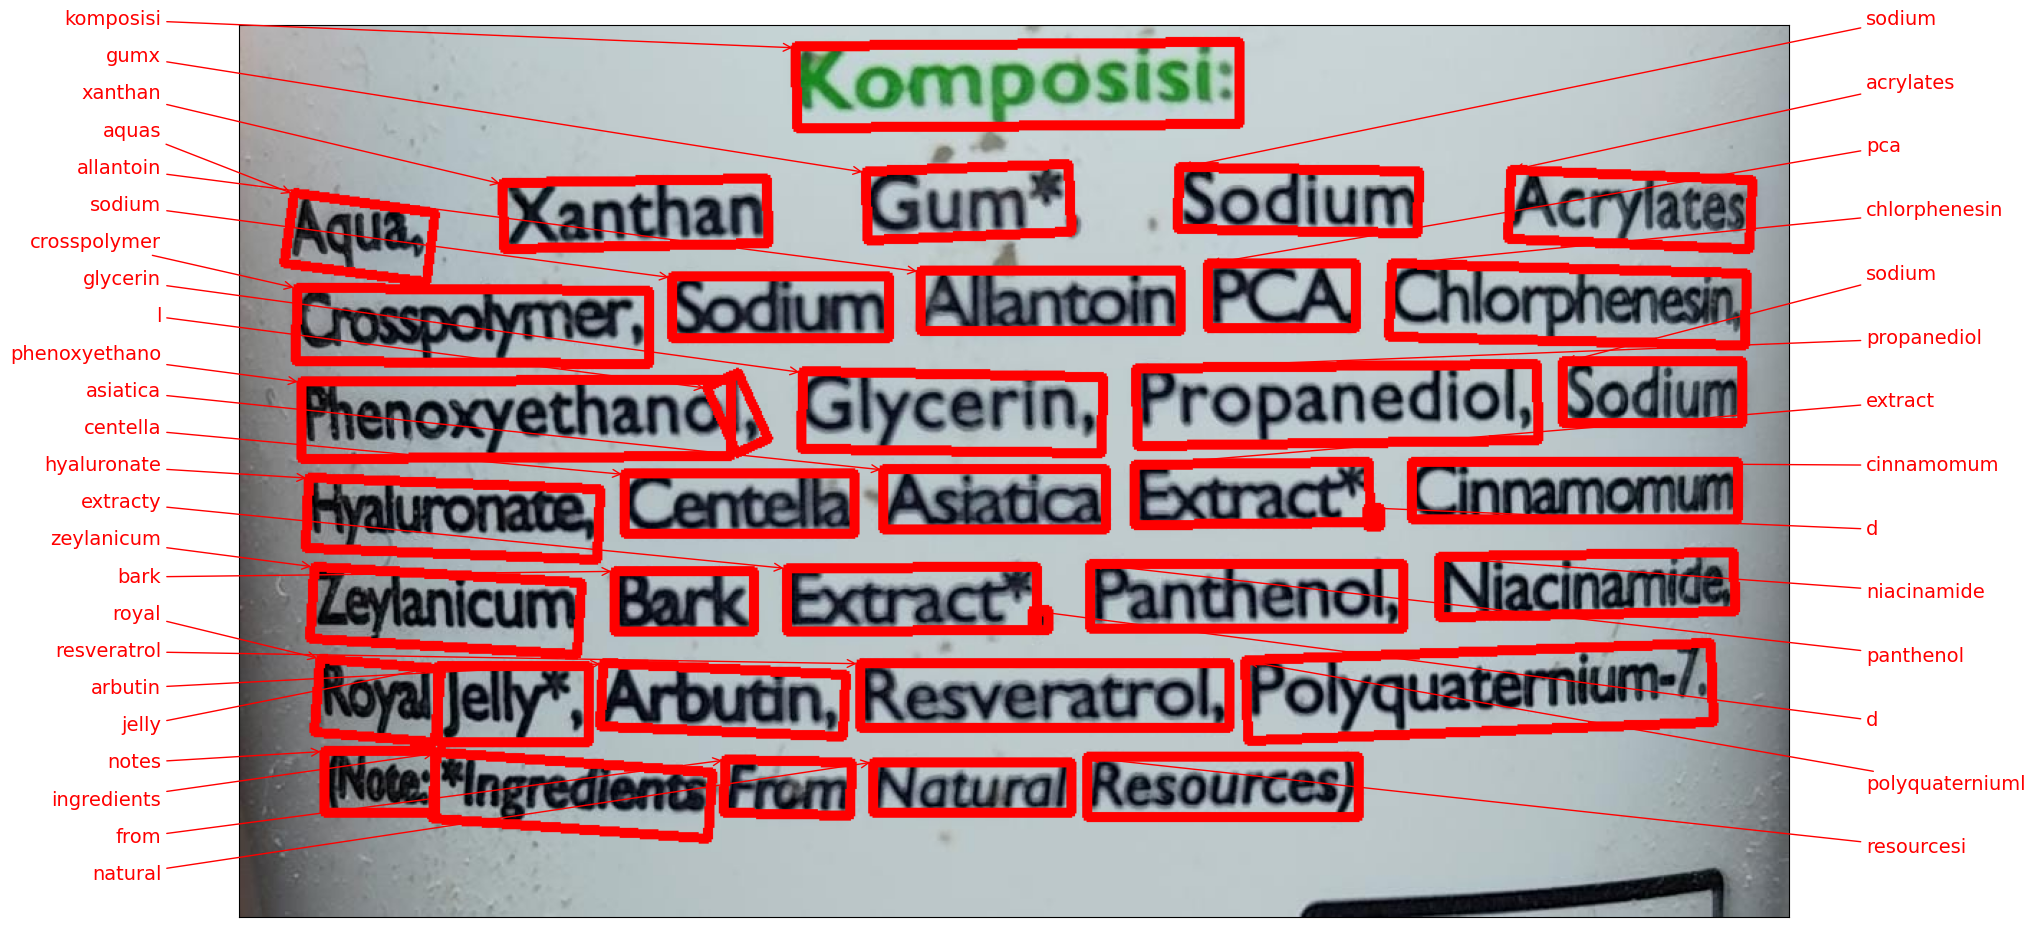

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image number 2
komposisi1 dataset/ingredient/img/komposisi1.jpg
New model result:
s komposish aqua watenh hydrogenated poly c812 oleninl glycerin dipropylene glycol caprylicicapnic ppgalo triglycenide methyl glucose ether pegzo sorbitan gycery isosteanate slearate steary alcohol dimethicone carbomer methyparaten sodium hyaluronate beheny alcohol tnethanclamine propylparaben phyostearocticodec lauroy glutamate disodium edta arachidy alcohol hydrolyzed nanosizea hyaluronic acid s sodium acetylated hyaluronater
Actually result:
Komposisi: Aqua (Water), Hydrogenated Poly (C6-12 Olefin), Glycerin, Dipropylene Glycol, Caprylic/Capric Triglyceride, PPG-10 Methyl Glucose Ether, PEG-20 Sorbitan Isostearate, Glyceryl Stearate, Stearyl Alcohol, Dimethicone, Carbomer, Methylparaben, Sodium Hyaluronate, Behenyl Alcohol, Triethanolamine, Propylparaben, Phytostearyl/Octyldodecyl Lauroyl Glutamate, Disodium EDTA, Arachidyl Alc

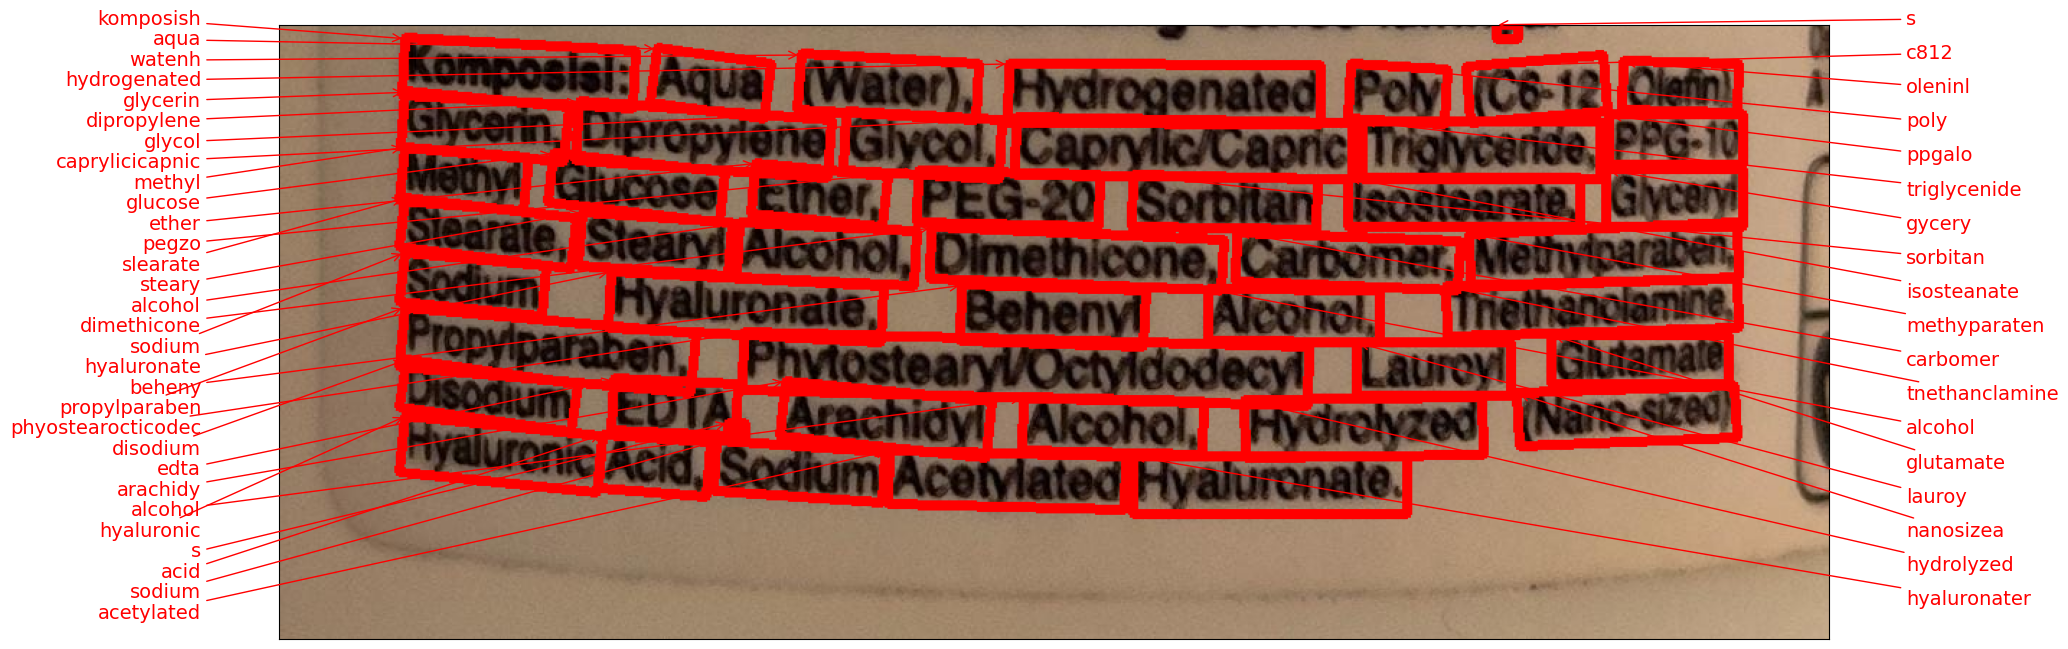

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image number 3
komposisi2 dataset/ingredient/img/komposisi2.jpg
New model result:
 s komposist glycerin aqua water butylene glycol ppg10 disodium methyl glucose ether methylparaben succinate sodium hyaluronate hydroxyethylcellos acid succinic acld hydrolyzed nanosized hyaluronic sodium acetylated hyaluronate
Actually result:
Komposisi: Aqua (Water), Butylene Glycol, Glycerin, PPG-10 Methyl Glucose Ether, Methylparaben, Disodium Succinate, Sodium Hyaluronate, Hydroxyethylcellulosa, Succinic Acid, Hydrolyzed (Nano-sized)  Hyaluronic Acid, Sodium Acetylated Hyaluronate.


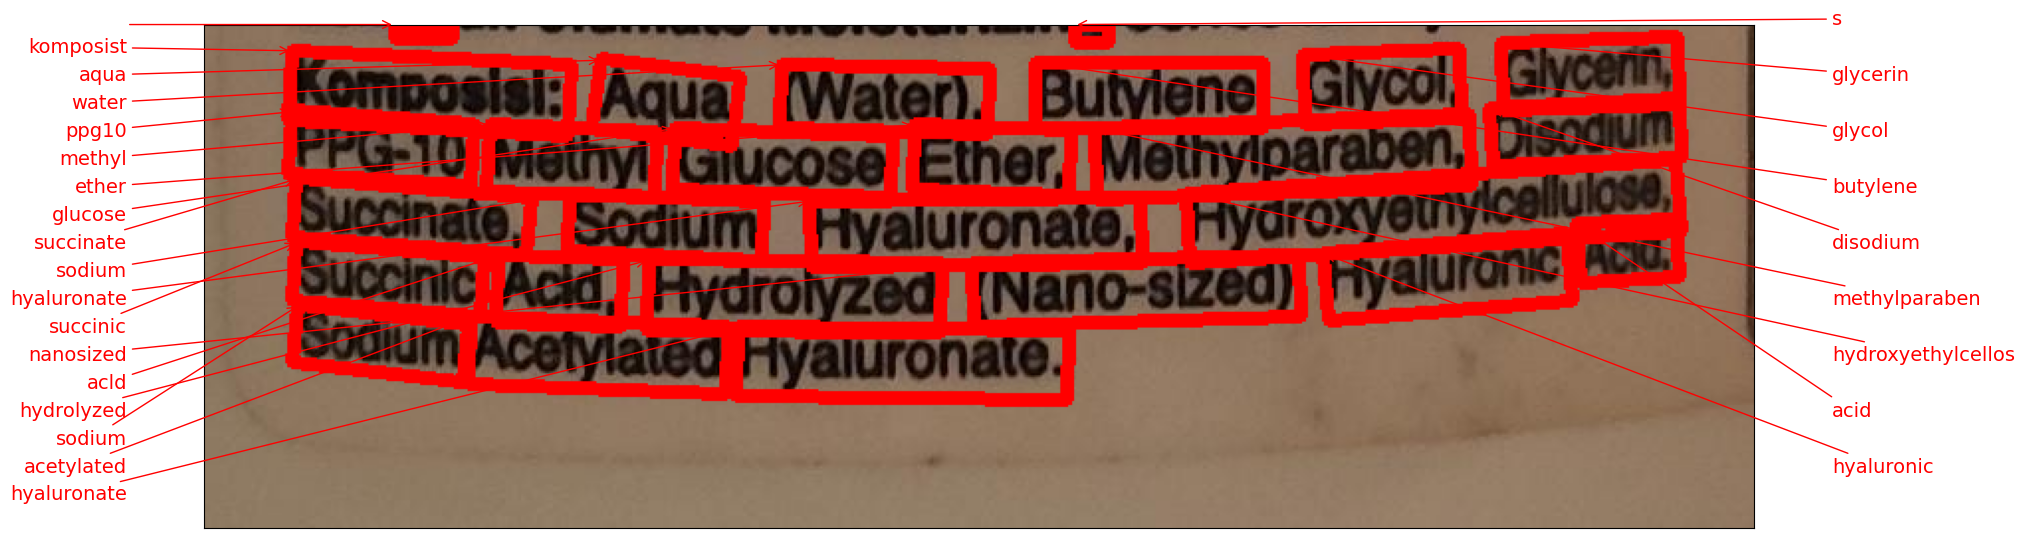

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Image number 4
komposisi3 dataset/ingredient/img/komposisi3.jpg
New model result:
komposisi aqua ethylhexyl methoxycinnamate asiprocia palmitate paralfinum liquidum glycerin cetyl alcohol dimethicone palmitic stearic acid cety palmitate pheneretanae stearate tapioca starch butyl methoxydibenzoylmethan carbomer glyceryl glucoside sodium hydroxice trisodium edia enetycoa propylparaben d myristic acid sodium ascorbyl phosphate propylene arachidic acid oleic acid vitis vinifera seed oil citric acid malpighia glabra fruit juice tridecethg myrciaria dubia fruit juice licorice glycyrrhiza glabra extract parh iaa
Actually result:
Komposisi: Aqua, Ethylhexyl Methoxycinnamate, Isopropyl Palmitate, Paraffinum Liquidum, Glycerin, Cetyl Alcohol, Dimethicone, Palmitic Acid, Stearic Acid, Cetyl Palmitate, Glyceryl Stearate, Tapioca Starch, Butyl Methoxydibenzoylmethane, Carbomer, Phenoxyethanol, Glyceryl Glucoside, Sodium Hyd

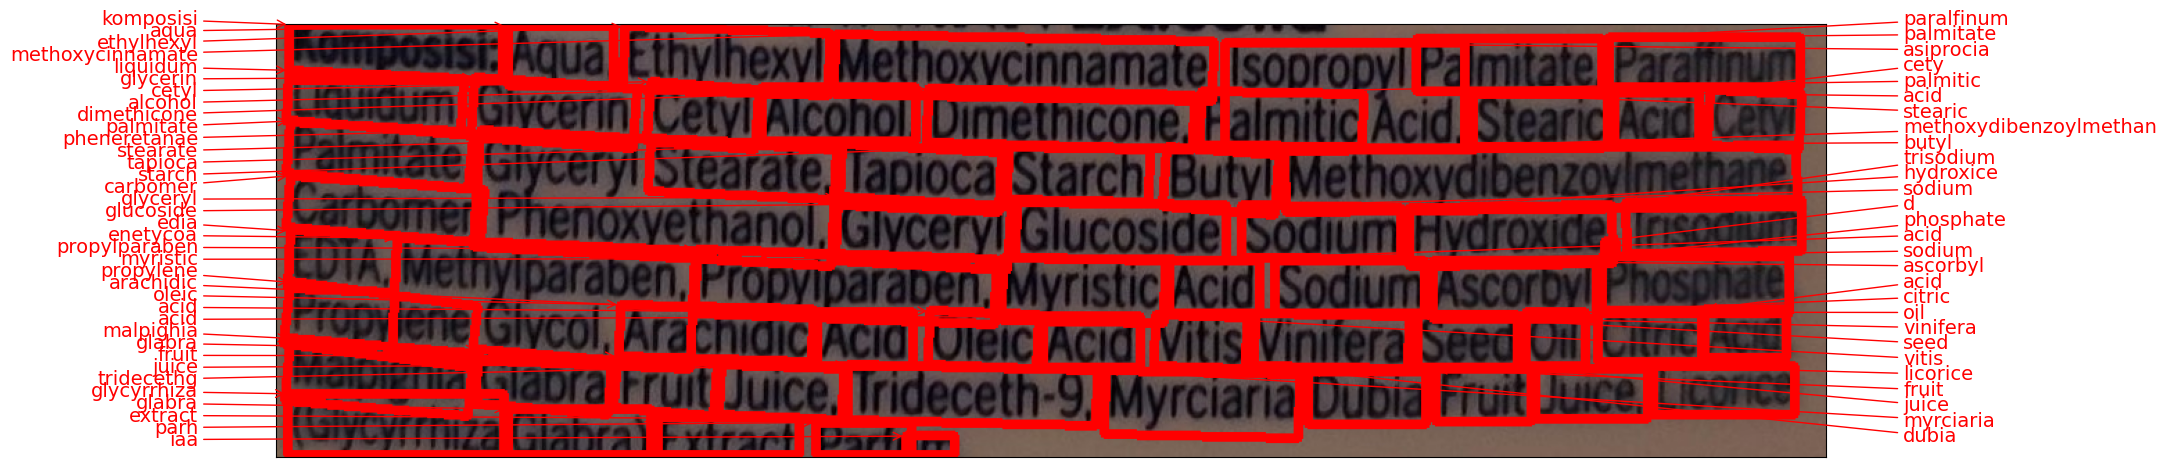

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image number 5
nivealain dataset/ingredient/img/nivealain.jpg
New model result:
to vitamin cyang terkandung dalam super foods dibandingkan dengan nivea intensive moisture tstratum body lotion corneum vitamin c derivative sodium ascorbyl phosphate komposisi aqua c1215 alkyl benzoate glycerin alcohol denat butyl methoxydibenzylmethan octocrylene phenylbenzimidazole sulfonic acid cetyl alcohol dimethicone palmitic acid stearic cetyl palmitate acid glyceryl stearate phenoxyethanol tapioca starch sodium hydroxide carbomer methylparaben ethylparaben trisodium edta myristic acid sodium ascorbyl phosphate arachidic acid creatine hydrolyzed pearl oleic acid persea gratissima oil propyene glycol maltodextrin citrus limon juice zingiber officinale root juice citric acid malpighia glabra fruit juice punica granatum fruit extract tridecethi sodium benzoate potassium sorbate camellia sinensis leaf extract citrus extract sine

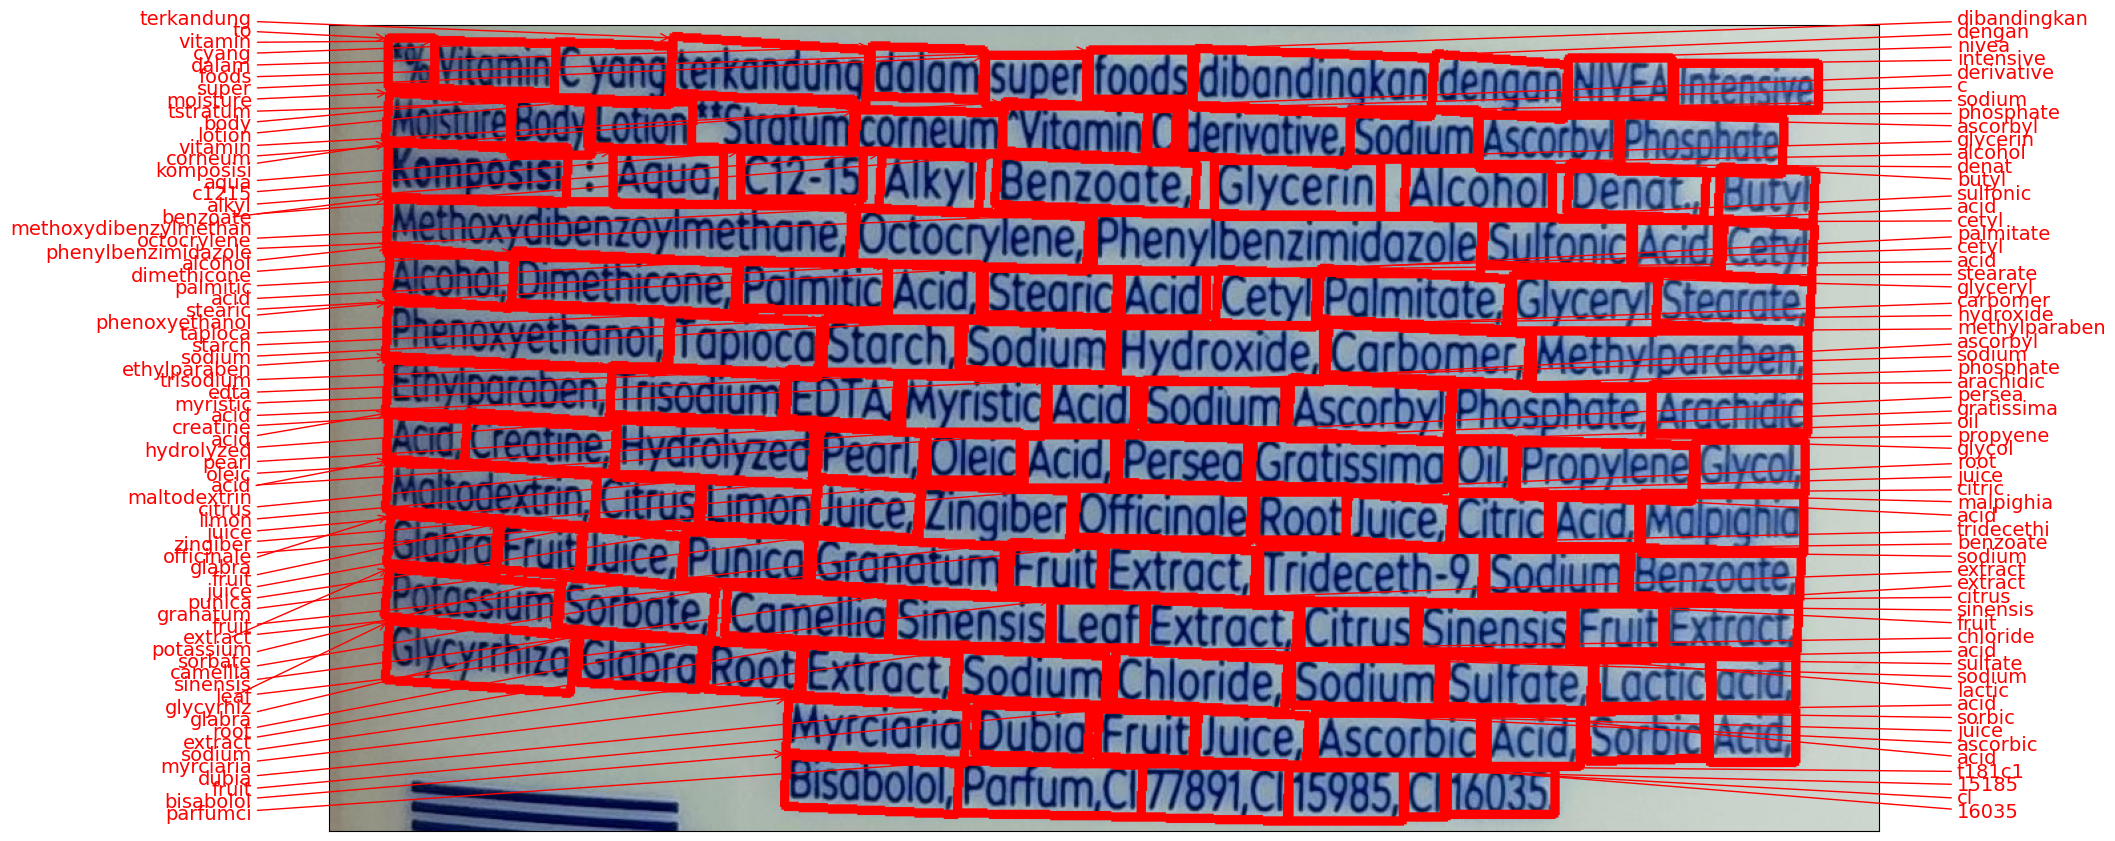

In [44]:
n = len(ingredient_images_names) # up to 130
n = 5 # test only first 5
for i in range(n):
    image_path =[(ingredient_images_path + ingredient_images_names[i] + f"{ext}") for ext in extensions if os.path.exists(ingredient_images_path + ingredient_images_names[i] + f"{ext}")]
    image = keras_ocr.tools.read(image_path[0])
    prediction_groups = pipeline.recognize([image])
    fig, ax = plt.subplots(figsize=(20, 20))
    keras_ocr.tools.drawAnnotations(image=image, predictions=prediction_groups[0], ax=ax)
    
    sorted_predictions = sorted(prediction_groups[0], 
                              key=lambda x: (round(x[1][0][1] / 10) * 10, x[1][0][0]))
    sorted_predictions_text = " ".join([word[0] for word in sorted_predictions])
    print("Image number", i+1)
    print(ingredient_images_names[i], image_path[0])
    print("New model result:")
    print(sorted_predictions_text)
    print("Actually result:")
    print(ingredient_labels[i])
    plt.show()
